# Andres Graterol - 4031393 - Fall 22
# Homework 3 Question 2 

## Generate The Data

In [325]:
# Import our libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [326]:
# Set up a gaussian prior
a = 1/2
m0 = np.transpose(np.zeros(2))
print("Shape of m0:", m0.shape)
print("m0", m0)

s0 = a*np.identity(2)
print("Shape of s0:", s0.shape)
print("s0", s0)

# Does this need to be of length n?
# Does this need to be done in the form of a multivariate gaussian?
#prior = np.random.normal(m0, s0)
prior = multivariate_normal(mean=m0, cov=s0, seed=1)
print("prior:", prior)

Shape of m0: (2,)
m0 [0. 0.]
Shape of s0: (2, 2)
s0 [[0.5 0. ]
 [0.  0.5]]
prior: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x0000026FA6D26820>


Data points: [ 3.62343464e-01  2.51204241e-01  1.11114031e+00  1.27615114e+00
  1.47767808e+00 -8.44865868e-02 -2.19844495e-01 -8.89720499e-01
 -1.09301479e+00 -1.20228999e+00  4.33661104e-01 -1.16229804e+00
  9.12573687e-01 -1.49596358e+00  1.39760168e-01  1.37151461e-01
  1.09755948e+00 -1.43467207e+00 -7.46152334e-01 -7.83039225e-01
  6.75383792e-01 -1.45909997e+00 -8.30232698e-01 -1.00496862e+00
  1.25574792e+00  1.14693291e+00 -7.86930435e-01  8.39964464e-01
 -9.57050048e-01  5.51167869e-01 -6.42474701e-01 -5.57491675e-02
 -9.68175577e-01 -1.18835251e+00  7.14170665e-01 -6.20971567e-01
 -3.79073924e-01  1.47095361e+00 -5.94829426e-03 -1.20540213e+00
 -1.18849729e+00  1.36737539e-01  6.93399985e-01 -8.77720718e-01
  5.01323346e-01  1.06728580e+00 -1.39643183e+00 -1.25032887e+00
  5.44424104e-01  6.26335566e-01 -1.33922769e+00 -4.34642948e-01
 -7.56376677e-01  1.07892934e-01 -1.03151204e+00 -2.20646424e-02
  1.31744226e+00  4.89755427e-01 -5.90051743e-01  7.61714637e-01
 -9.77273156

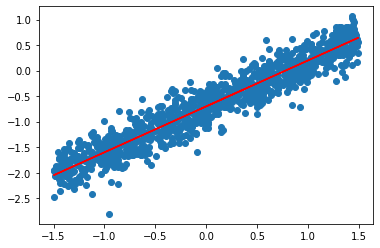

In [364]:
# Variables
N = 1000
variance = 0.25

# Intercept
w0 = -0.7
# slope
w1 = 0.9

# Generating N data points uniform in the interval [-3/2, 3/2]
data_points = np.random.uniform(low = (-3/2), high = (3/2), size = (N,))
#data_points = np.linspace((-3/2), (3/2), N)

noise = np.random.normal(0, variance, len(data_points))

linear_model = w0 + w1*data_points

targets = linear_model + noise
#print(len(targets))

plt.plot(data_points, linear_model, 'red')
plt.scatter(data_points, targets)

## Posterior Update

In [328]:
# Function to compute the design matrix
def compute_design_matrix(input_data):
    matrix = []
    for x in input_data:
        matrix.append([0, x])
    
    #print("Check data", input_data)
    matrix = np.array(matrix)
    #print("Shape of matrix:", matrix.shape)   
    #print(matrix)
    
    return matrix

(1000, 2)
Sn shape: (2, 2)
Mn shape: (2,)
total posterior <scipy.stats._multivariate.multivariate_normal_frozen object at 0x0000026FB72B49A0>


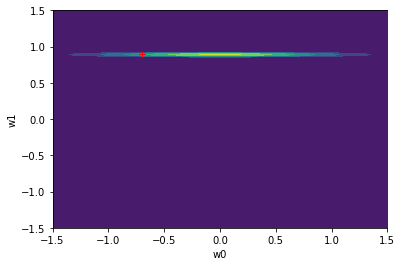

samples: [[-0.90653889  0.90342656]
 [ 0.55693004  0.87639238]
 [ 0.07581182  0.86731713]
 [ 0.64780918  0.88946602]
 [-0.51887495  0.89404411]
 [-0.2648243   0.87008204]]


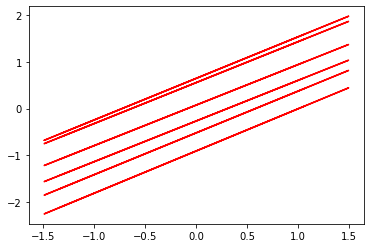

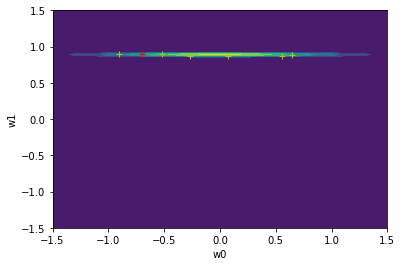

In [352]:
# Plot the posterior of the parameters given all the data x, t
# Obtain the design matrix 
phi = compute_design_matrix(data_points)
print(phi.shape)

Sn = np.linalg.inv(np.linalg.inv(s0) + ((1/variance)*(np.matmul(np.transpose(phi), phi))))
Mn = np.matmul(Sn, (np.matmul(np.linalg.inv(s0), m0) + ((1/variance)*np.matmul(np.transpose(phi), targets))))
print("Sn shape:", Sn.shape)
print("Mn shape:", Mn.shape)

total_posterior = multivariate_normal(mean=Mn, cov=Sn)
print("total posterior", total_posterior)

X = np.linspace(-3/2, 3/2, N)
Y = np.linspace(-3/2, 3/2, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))

Z = total_posterior.pdf(pos)

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
plt.contourf(X, Y, Z)
plt.show()

#samples_list = []

#for i in range(6):
#    samples = total_posterior.rvs()
#    samples_list.append(samples)
    
samples_list = (np.random.multivariate_normal(Mn, Sn, size=6))
    
print("samples:", samples_list)

for s in samples_list:
    line = s[0] + s[1]*data_points
    plt.plot(data_points, line, 'red')

plt.show()    

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
for s in samples_list:
    plt.plot(s[0], s[1], 'y+')
plt.contourf(X, Y, Z)
plt.show()

samples: [[ 0.61884783 -0.68647371]
 [ 0.47482222  0.58337403]
 [ 0.21529481  0.55285003]
 [ 0.36389078  0.79609485]
 [ 1.06569676  1.30240762]
 [-1.11193256 -0.49296522]]


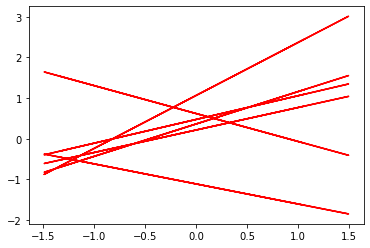

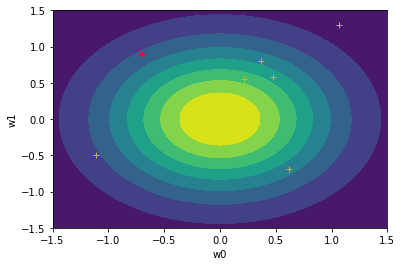

In [357]:
# Plot the assumed multivariate gaussian prior
Z = prior.pdf(pos)

# TODO: Possibly make these deterministic 
#     : CHECK WHY SOMETIMES THEY GO OUT OF RANGE!
# Pick 6 realizations from the prior
# We will pick one to compute the likelihood for 
samples_list = (np.random.multivariate_normal(m0, s0, size=6))

#for i in range(6):
#    samples = prior.rvs()
#    samples_list.append(samples)
    
print("samples:", samples_list)

for s in samples_list:
    line = s[0] + s[1]*data_points
    plt.plot(data_points, line, 'red')

plt.show()    

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
for s in samples_list:
    plt.plot(s[0], s[1], 'y+')
plt.contourf(X, Y, Z)
plt.show()
# Method to update the posterior distribution 
# given a dataset and the prior

Chosen weights: [[-1.11193256]
 [-0.49296522]]
phi [0.         1.05969528]
Shape of weights: (2, 1)
Shape of phi: (2,)
Likelihood mean: [-0.52239292]
m shape: (1,)
covariance shape (2, 2)
likelihood: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x0000026FA6803DF0>


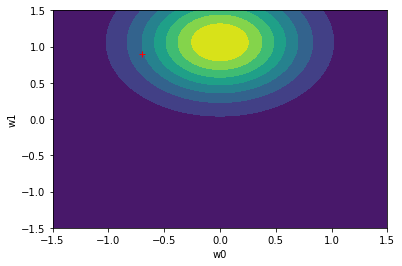

In [358]:
# Now to test the likelihood looks right
# test with the first set of points 
phi_x = np.array([0, data_points[0]])
#phi_x = phi_x[: , np.newaxis]

# Pick an arbitrary weight combination from our samples 
weights = random.choice(samples_list)
weights = weights[: , np.newaxis]

print("Chosen weights:", weights)
print("phi", phi_x)
print("Shape of weights:", weights.shape)
print("Shape of phi:", np.transpose(phi_x).shape)

likelihood_mean = np.matmul(np.transpose(phi_x), weights)
print("Likelihood mean:", likelihood_mean)
print("m shape:", likelihood_mean.shape)

covariance = variance * np.identity(2)
print("covariance shape", covariance.shape)
likelihood = multivariate_normal(mean=np.transpose(phi_x), cov=covariance)
print("likelihood:", likelihood)

Z = likelihood.pdf(pos)

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
plt.contourf(X, Y, Z)
plt.show()

Shape of m0: (2,)
m0 [0. 0.]
Shape of s0: (2, 2)
s0 [[0.5 0. ]
 [0.  0.5]]
[ 3.62343464e-01  2.51204241e-01  1.11114031e+00  1.27615114e+00
  1.47767808e+00 -8.44865868e-02 -2.19844495e-01 -8.89720499e-01
 -1.09301479e+00 -1.20228999e+00  4.33661104e-01 -1.16229804e+00
  9.12573687e-01 -1.49596358e+00  1.39760168e-01  1.37151461e-01
  1.09755948e+00 -1.43467207e+00 -7.46152334e-01 -7.83039225e-01
  6.75383792e-01 -1.45909997e+00 -8.30232698e-01 -1.00496862e+00
  1.25574792e+00  1.14693291e+00 -7.86930435e-01  8.39964464e-01
 -9.57050048e-01  5.51167869e-01 -6.42474701e-01 -5.57491675e-02
 -9.68175577e-01 -1.18835251e+00  7.14170665e-01 -6.20971567e-01
 -3.79073924e-01  1.47095361e+00 -5.94829426e-03 -1.20540213e+00
 -1.18849729e+00  1.36737539e-01  6.93399985e-01 -8.77720718e-01
  5.01323346e-01  1.06728580e+00 -1.39643183e+00 -1.25032887e+00
  5.44424104e-01  6.26335566e-01 -1.33922769e+00 -4.34642948e-01
 -7.56376677e-01  1.07892934e-01 -1.03151204e+00 -2.20646424e-02
  1.31744226e+0

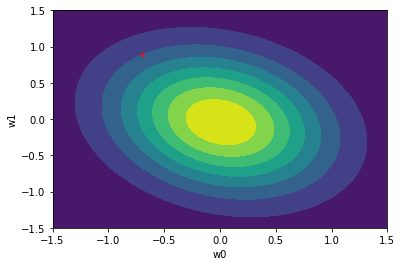

samples: [[-0.72756334  0.14601632]
 [ 1.00682591 -1.14546891]
 [-0.20942028  0.43453405]
 [-0.01539745  0.47727393]
 [ 0.68073751  1.24380018]
 [ 1.4508563   0.68082386]]


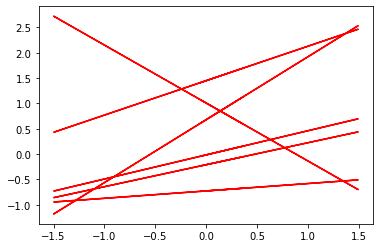

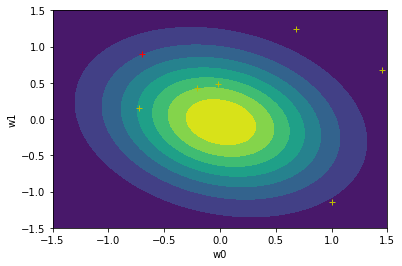

Current phi_x [0.         0.25120424]
current target: -0.6165873400366919
New Posterior_mean: [ 0.07872836 -0.2812228 ]
New Posterior_variance: [[ 0.39064022 -0.10935978]
 [-0.10935978  0.39064022]]
We have seen 2 data point(s)
Data point we used: 0.25120424144312414


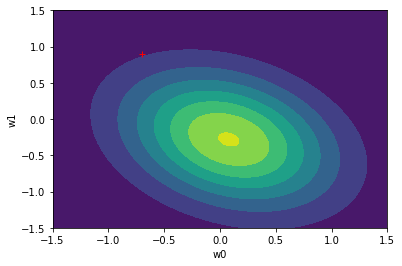

samples: [[-0.34016018 -0.45764208]
 [-0.20249451  0.80167063]
 [ 0.37428242 -0.6800202 ]
 [ 0.57880835 -1.51011582]
 [ 0.57831456  0.16099061]
 [-1.12031046 -1.10069303]]


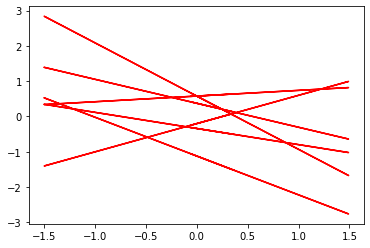

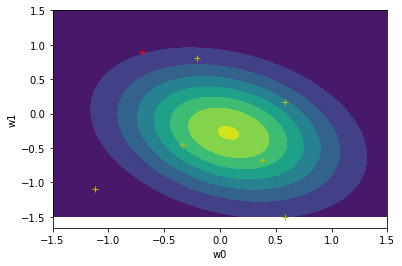

Current phi_x [0.         1.11114031]
current target: 0.4183643084461798
New Posterior_mean: [-0.24246763  0.32730411]
New Posterior_variance: [[ 0.28722389 -0.21277611]
 [-0.21277611  0.28722389]]
We have seen 3 data point(s)
Data point we used: 1.1111403134270152


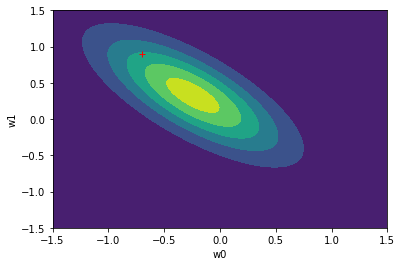

samples: [[-0.36423449 -0.04595129]
 [ 0.14917994 -0.33287346]
 [ 0.11794495  0.0181146 ]
 [-1.0275182   0.80821478]
 [-0.71949431  0.61470428]
 [-0.46111284  0.16413667]]


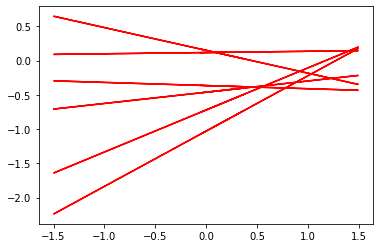

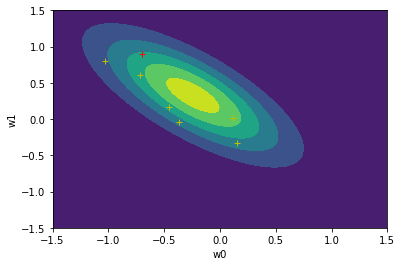

Current phi_x [0.         1.27615114]
current target: 0.5142524901296768
New Posterior_mean: [-0.87001418  1.01228536]
New Posterior_variance: [[ 0.26889593 -0.23110407]
 [-0.23110407  0.26889593]]
Current phi_x [0.         1.47767808]
current target: 0.4888449935325512
New Posterior_mean: [-1.58776919  1.73924141]
New Posterior_variance: [[ 0.26138201 -0.23861799]
 [-0.23861799  0.26138201]]
Current phi_x [ 0.         -0.08448659]
current target: -0.5053145491838336
New Posterior_mean: [-1.62861864  1.78377656]
New Posterior_variance: [[ 0.26136723 -0.23863277]
 [-0.23863277  0.26136723]]
Current phi_x [ 0.         -0.21984449]
current target: -0.6590243121926368
New Posterior_mean: [-1.76764725  1.93451369]
New Posterior_variance: [[ 0.26126818 -0.23873182]
 [-0.23873182  0.26126818]]
Current phi_x [ 0.        -0.8897205]
current target: -1.2665964255656048
New Posterior_mean: [-2.86053493  3.09545962]
New Posterior_variance: [[ 0.25986085 -0.24013915]
 [-0.24013915  0.25986085]]
Cur

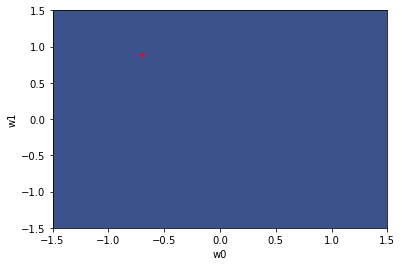

samples: [[-626.70305453  627.15266961]
 [-626.7905795   627.23575077]
 [-626.76441111  627.23578842]
 [-626.3464825   626.77394781]
 [-627.88163976  628.32047467]
 [-627.40010197  627.82360366]]


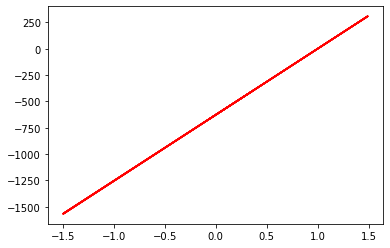

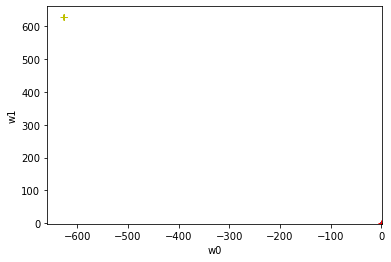

In [374]:
#Sn = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*(np.matmul(np.transpose(phi), phi)))
#Mn = np.matmul(Sn, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*np.matmul(np.transpose(phi), targets)))
a = 1/2
m0 = np.transpose(np.zeros(2))
print("Shape of m0:", m0.shape)
print("m0", m0)

s0 = a*np.identity(2)
print("Shape of s0:", s0.shape)
print("s0", s0)
print(data_points)

# Pass in data: (x,t) and the mean and variance of the prior
def update_posterior(data_points, targets, m0, s0):
    # Iterate through every point 
    for i in range(N):
        
        # find phi of the data point we are looking at:
        phi_x = np.array([0, data_points[i]])
        
        print("Current phi_x", phi_x)
        print("current target:", targets[i])
        
        # Find the posterior covariance and the mean with the help of likelihood and prior information
        posterior_covariance = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*np.matmul(np.transpose(phi_x), phi_x)) 
        posterior_mean = np.matmul(posterior_covariance, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*np.multiply(np.transpose(phi_x), targets[i])))
        
        print("New Posterior_mean:", posterior_mean)
        print("New Posterior_variance:", posterior_covariance)
        
        # Update the posterior to become the new prior
        s0 = posterior_covariance
        m0 = posterior_mean
        
        # Plot the contour after seeing 1, 5, 100, 500, and 1000 data points
        if (i == 0 or i == 1 or i == 2 or i == 999):
            print(f"We have seen {i+1} data point(s)")
            print("Data point we used:", data_points[i])
            posterior = multivariate_normal(mean=m0, cov=s0)
            Z = posterior.pdf(pos)

            plt.xlabel("w0")
            plt.ylabel("w1")
            plt.plot(w0, w1, 'r+')
            plt.contourf(X, Y, Z)
            plt.show()
            
            samples_list = (np.random.multivariate_normal(posterior_mean, posterior_covariance, size=6))

            #for i in range(6):
            #    samples = posterior.rvs()
            #    samples_list.append(samples)

            print("samples:", samples_list)

            for s in samples_list:
                line = s[0] + s[1]*data_points
                plt.plot(data_points, line, 'red')

            plt.show()    

            plt.xlabel("w0")
            plt.ylabel("w1")
            plt.plot(w0, w1, 'r+')
            for s in samples_list:
                plt.plot(s[0], s[1], 'y+')
            plt.contourf(X, Y, Z)
            plt.show()
    

update_posterior(data_points, targets, m0, s0)

In [333]:
#posterior_covariance = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*np.matmul(np.transpose(phi_x), phi_x)) 
#posterior_mean = np.matmul(posterior_covariance, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*np.multiply(np.transpose(phi_x), targets[0])))

#posterior = multivariate_normal(mean=posterior_mean, cov=posterior_covariance)

#Z = posterior.pdf(pos)

#plt.xlabel("w0")
#plt.ylabel("w1")
#plt.plot(w0, w1, 'r+')
#plt.contourf(X, Y, Z)
#plt.show()